In [ ]:
from grasp_generator import GraspGenerator
from environment.utilities import Camera
from environment.env import Environment
from utils import YcbObjects, PackPileData, IsolatedObjData, summarize
import numpy as np
import pybullet as p
import argparse
import os
import sys
import cv2
import math
import matplotlib.pyplot as plt
import time
import skimage.io

from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.coco import coco

# Root directory of the project
ROOT_DIR = os.path.abspath('/home/ivar/Documents/Thesis/clutterbot/')

In [ ]:
def make_mask(vis):
    CAM_Z = 1.9
    IMG_SIZE = 224

    objects = YcbObjects('objects/ycb_objects',
                        mod_orn=['ChipsCan', 'MustardBottle', 'TomatoSoupCan'],
                        mod_stiffness=['Strawberry'])
    
    cracker_path = 'objects/ycb_objects/YcbCrackerBox/model.urdf'
    hammer_path = 'objects/ycb_objects/YcbHammer/model.urdf'
    banana_path = 'objects/ycb_objects/YcbBanana/model.urdf'

    ## camera settings: cam_pos, cam_target, near, far, size, fov
    center_x, center_y, center_z = 0.05, -0.52, CAM_Z
    camera = Camera((center_x, center_y, center_z), (center_x, center_y, 0.785), 0.2, 2.0, (IMG_SIZE, IMG_SIZE), 40)
    env = Environment(camera, vis=vis, finger_length=0.06)

    env.reset_robot()          
    env.remove_all_obj()                        
    
    env.load_isolated_obj(banana_path)

    # number_of_objects = 5
    # objects.shuffle_objects()
    # info = objects.get_n_first_obj_info(number_of_objects)
    # env.create_pile(info)

    # segmentation mask of the image where pixels each contain unique integers with object IDs
    # yields integer values: upper rectangle of 1, lower of 4
    # with mask as 6 (in the case of single object!!)
    _, _, seg = camera.get_cam_img()

    ## convert to numpy and binarize (i.e. filter for 6, since value for single mask)
    numpy_mask = (np.array(seg) == 6).astype(int)

    ## convert back to matrix
    mask = np.asmatrix(numpy_mask)

    plt.imshow(mask, interpolation='nearest')
    plt.show()
    # skimage.io.imshow(np.asmatrix(seg))


In [ ]:
def look_at_banana(vis):
    CAM_Z = 1.9
    IMG_SIZE = 224

    def setup_mrcnn():
        # Directory to save logs and trained model
        MODEL_DIR = os.path.join(ROOT_DIR, 'logs')
        # Local path to your trained weights file
        COCO_MODEL_PATH = os.path.join(ROOT_DIR, 'mrcnn/weights/mask_rcnn_coco.h5')

        class InferenceConfig(coco.CocoConfig):
            GPU_COUNT = 1
            IMAGES_PER_GPU = 1
            
        config = InferenceConfig()

        class_names = ['BG', 'person', 'bicycle', 'car', 'motorcycle', 'airplane',
                    'bus', 'train', 'truck', 'boat', 'traffic light',
                    'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird',
                    'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear',
                    'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie',
                    'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
                    'kite', 'baseball bat', 'baseball glove', 'skateboard',
                    'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup',
                    'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
                    'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
                    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed',
                    'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote',
                    'keyboard', 'cell phone', 'microwave', 'oven', 'toaster',
                    'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors',
                    'teddy bear', 'hair drier', 'toothbrush']

        # Create model object in inference mode.
        model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR, config=config)

        # Load weights trained on the COCO dataset 
        model.load_weights(COCO_MODEL_PATH, by_name=True)

        return model, class_names

    model, class_names = setup_mrcnn()

    def evaluate():
        start = time.time()

        results = model.detect([rgb], verbose=1)
        r = results[0]
        box, mask, classID, score = r['rois'], r['masks'], r['class_ids'], r['scores']                      

        end = time.time()
        print('MRCNN EXECUTION TIME: ', end - start)

        return box, mask, classID, score

    objects = YcbObjects('objects/ycb_objects',
                        mod_orn=['ChipsCan', 'MustardBottle', 'TomatoSoupCan'],
                        mod_stiffness=['Strawberry'])
    
    banana_path = 'objects/ycb_objects/YcbBanana/model.urdf'

    ## camera settings: cam_pos, cam_target, near, far, size, fov
    center_x, center_y, center_z = 0.05, -0.52, CAM_Z
    # camera = Camera((center_x, center_y, center_z), (center_x, center_y, 0.785), 0.2, 2.0, (self.IMG_SIZE, self.IMG_SIZE), 40)
    
    MRCNN_IMG_SIZE = 1024
    camera = Camera((center_x, center_y, center_z), (center_x, center_y, 0.785), 0.2, 2.0, (MRCNN_IMG_SIZE, MRCNN_IMG_SIZE), 40)
    env = Environment(camera, vis=vis, finger_length=0.06)

    env.reset_robot()          
    env.remove_all_obj()                        
    
    # load banana into environment
    env.load_isolated_obj(banana_path)

    number_of_objects = 5
    # objects.shuffle_objects()
    # info = objects.get_n_first_obj_info(number_of_objects)
    # env.create_pile(info)

    rgb, _, _ = camera.get_cam_img()

    
    # for i in range(7):
    #     start = time.time()
    #     # path = 'trained_models/Mask_RCNN/images/' + str(i) + '.jpg'
    #     path = 'images/' + str(i) + '.jpg'
    #     print(path)
    #     rgb = skimage.io.imread(path)
    #     results = model.detect([rgb], verbose=1)
    #     r = results[0]
    #     box, mask, classID, score = r['rois'], r['masks'], r['class_ids'], r['scores']

    #     end = time.time()
    #     print('MRCNN EXECUTION TIME: ', end - start)

    #     visualize.display_instances(rgb, box, mask, classID, class_names, score)

    bananaFound = False
    nfNumber = 1

    box, mask, classID, score = evaluate()

    while(not bananaFound):
        if (47 in classID):
            print('BANANA FOUND')
            bananaFound = True

            result = np.where(classID == 47)
            index = result[0][0]
            print('index: ', index)
            # terminaloutput>> index:  (array([3]),)
            # pak eerste output: result = np.where(classID == 47) \ index = result[0][0]
            # https://thispointer.com/find-the-index-of-a-value-in-numpy-array/
        else:
            print('NOT FOUND, starting again')

            # visualize.display_instances(rgb, box, mask, classID, class_names, score, title='notfound ' + str(nfNumber))
            
            nfNumber += 1

            env.reset_robot()          
            env.remove_all_obj()
            objects.shuffle_objects()
            info = objects.get_n_first_obj_info(number_of_objects)
            env.create_pile(info)

            rgb, _, _ = camera.get_cam_img()

            box, mask, classID, score = evaluate()
    
    print('NOT FOUND #', nfNumber)
    visualize.display_instances(rgb, box, mask, classID, class_names, score)


In [ ]:
def make_data():
    ## Call json.dumps(obj) with obj as the list to serialize the list to a JSON formatted string.
    
    # print(arr)
    
    # # Output
    # # [[1 2]
    # # [3 4]]

    # lists = arr.tolist()
    # json_str = json.dumps(lists)
    # print(json_str)

    # # Output
    # # [[1, 2], [3, 4]]
    pass


In [1]:
import json

dataset_dir = 'data/trial'

json_file = 'trial.json'
annotations1 = json.load(open(os.path.join(dataset_dir, json_file)))


In [10]:
annotations = list(annotations1.values())
print(annotations)

[{'path': 'sample1.jpg', 'width': 224, 'height': 224}, {'path': 'sample2.jpg', 'width': 224, 'height': 224}]


In [28]:
import numpy as np

zeros = np.zeros((5,5), int)

mask = zeros
mask[1][2] = 1
mask[2][2] = 1
mask[3][2] = 1


In [35]:
print(mask)
mask_lists = mask.tolist()
js_str = json.dumps(mask_lists)


print(js_str)

[[0 0 0 0 0]
 [0 0 1 0 0]
 [0 0 1 0 0]
 [0 0 1 0 0]
 [0 0 0 0 0]]
[[0, 0, 0, 0, 0], [0, 0, 1, 0, 0], [0, 0, 1, 0, 0], [0, 0, 1, 0, 0], [0, 0, 0, 0, 0]]


In [62]:
dict = {}

for it in range(2):
    path = "path" + str(it) + ".jpg"
    id = it
    mask_lists = mask_lists

    inst1 = {
        "path": path,
        "id": id,
        "mask": mask_lists
    }

    dict[it] = inst1

print(dict)
js_str = json.dumps(dict)

{0: {'path': 'path0.jpg', 'id': 0, 'mask': [[0, 0, 0, 0, 0], [0, 0, 1, 0, 0], [0, 0, 1, 0, 0], [0, 0, 1, 0, 0], [0, 0, 0, 0, 0]]}, 1: {'path': 'path1.jpg', 'id': 1, 'mask': [[0, 0, 0, 0, 0], [0, 0, 1, 0, 0], [0, 0, 1, 0, 0], [0, 0, 1, 0, 0], [0, 0, 0, 0, 0]]}}


In [63]:
path = "path2.jpg"
id = 2
mask_lists = mask_lists

inst2 = {
    "path": path,
    "id": id,
    "mask": mask_lists
}

dict[2] = inst2

with open("datafile.json", "w") as write:
    json.dump(dict, write)

50176
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


/tmp/ipykernel_9857/3156545820.py:17: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask2 = mask.astype(np.bool)
/home/ivar/anaconda3/lib/python3.9/site-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


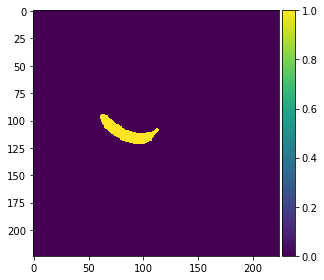

In [10]:
import matplotlib.pyplot as plt
import numpy as np
import json
import skimage.io

annotations1 = json.load(open('test1.json'))
ann = list(annotations1.values())

# print(ann)

inst1 = ann[0]
mask_list = inst1['mask']
mask = np.array(mask_list)
# print(np.matrix(mask))
print(mask.size)

mask2 = mask.astype(np.bool)

# plt.imshow(mask)
skimage.io.imshow(mask)

print(mask)


In [77]:
mask = np.zeros((5,5), int)

mask[0][2] = 6
mask[1][2] = 6
mask[2][2] = 6
mask[3][2] = 6
mask[4][2] = 6

result = np.where(mask == 6)
print(result)
# print(mask)
c_list = list(zip(result[0], result[1]))

print(c_list)
print(c_list[1])

(array([0, 1, 2, 3, 4]), array([2, 2, 2, 2, 2]))
[(0, 2), (1, 2), (2, 2), (3, 2), (4, 2)]
(1, 2)


In [ ]:
import matplotlib.pyplot as plt

annotations1 = json.load(open('newMask.json'))
ann = list(annotations1.values())

# print(ann)

inst = ann[0]

mask = np.zeros(shape=(inst['height'],inst['width']))
#print event.x, event.y
mask[inst['mask_y'],inst['mask_x']]=1

plt.imshow(mask)

In [10]:
import random

bool(random.getrandbits(1))

False

In [ ]:
import imgaug.imgaug as ia
import skimage.io

img = skimage.io.imread('data/train/GelatinBox12.jpg')
skimage.io.imshow(img)

In [11]:
class_names = ['BG', 'person', 'bicycle', 'car', 'motorcycle', 'airplane',
                    'bus', 'train', 'truck', 'boat', 'traffic light',
                    'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird',
                    'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear',
                    'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie',
                    'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
                    'kite', 'baseball bat', 'baseball glove', 'skateboard',
                    'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup',
                    'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
                    'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
                    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed',
                    'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote',
                    'keyboard', 'cell phone', 'microwave', 'oven', 'toaster',
                    'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors',
                    'teddy bear', 'hair drier', 'toothbrush']
print(len(class_names))

81


TypeError: object of type 'int' has no len()

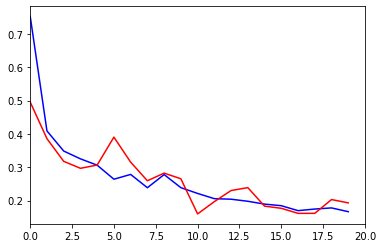

In [20]:
import matplotlib.pyplot as plt

loss = [1.1854, 0.6303, 0.5300, 0.4471, 0.3668, 0.3818, 0.3519, 0.3243, 0.3217, 0.2790,  0.2806, 0.2720, 0.2712, 0.2580, 0.2468, 0.2446, 0.2336, 0.2119, 0.2258, 0.2184, 0.2039, 0.2062, 0.2179, 0.1969, 0.1861, 0.1846, 0.1862, 0.1799, 0.2046, 0.1752, 0.1701, 0.1734, 0.1577, 0.1603, 0.1637, 0.1622, 0.1674, 0.1594, 0.1491, 0.1512]

val = [0.7095, 0.6066, 0.6826, 0.4511, 0.5400, 0.3894, 0.2554, 0.2673, 0.2726, 0.3397, 0.3223, 0.2163, 0.2183, 0.1952, 0.2046, 0.2100, 0.2505, 0.2568, 0.2263, 0.3240, 0.2153, 0.2642, 0.1634, 0.1830, 0.1943, 0.2243, 0.1232, 0.1529, 0.1783, 0.1943, 0.1483, 0.1383, 0.1829, 0.1319, 0.1848, 0.1452, 0.1530, 0.1272, 0.1695, 0.1549]

loss = [0.7527, 0.4090, 0.3487, 0.3253, 0.3063, 0.2642, 0.2786, 0.2387, 0.2781, 0.2389, 0.2216, 0.2059, 0.2043, 0.1981, 0.1896, 0.1848, 0.1700, 0.1748, 0.1782, 0.1669]

val = [0.4954, 0.3858, 0.3179, 0.2969, 0.3067, 0.3904, 0.3154, 0.2596, 0.2825, 0.2655, 0.1602, 0.1971, 0.2303, 0.2390, 0.1835, 0.1770, 0.1619, 0.1619, 0.2032, 0.1933]

plt.plot(loss, '-b', label='loss')
plt.plot(val, '-r', label='val')

plt.xlim([0, 20])
# plt.ylim([0, 1.0])

plt.xlabel("epoch")
plt.legend(loc='upper right')
plt.title('Training loss vs validation loss')

# plt.plot(loss)
# plt.show()

# plt.rcParams['axes.facecolor']='white'
plt.rcParams['savefig.facecolor']='white'
plt.savefig('my_plot.png')
# plt.savefig('whatever.png', facecolor=plt.get_facecolor(), edgecolor='none')


In [ ]:
from sklearn.metrics import confusion_matrix, plot_confusion_matrix

def plot_conf_matrix(predictions, y_test, ss):
    matrix = confusion_matrix(labelizer.inverse_transform(y_test.argmax(axis=1)), 
                          labelizer.inverse_transform(predictions.argmax(axis=1)), 
                         labels=labelizer.classes_
                         )

    matrix = pd.DataFrame(matrix, index=labelizer.classes_, columns=labelizer.classes_)

    fig, ax = plt.subplots(figsize=(8, 8))

    sns.set(font_scale=2.5)
    sns.heatmap(matrix, annot=True, fmt='.2f', linewidth=5, cmap="Greens")
    ax.set_title('Confusion Matrix for (mis)classifications \n with sample size: '+str(ss)+ ' seconds')
    ax.set_xlabel('Predictions')
    ax.set_ylabel('True values');

    fig.savefig('conf_matrix_size_'+str(ss)+'.png', bbox_inches='tight') #

conf_matrix_data += [(predictions, y_test, i)]

for j in conf_matrix_data:
    plot_conf_matrix(j[0], j[1], j[2])